<a href="https://colab.research.google.com/github/MachokaGit/Electrical-Usage-Forecast-FB-Prophet/blob/main/Forecast_with_Exogenous_Prophet_2nd%20Trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import xgboost as xgb
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd
data = pd.read_csv('Elec_Data.csv',parse_dates=['Date'])
data

<ipython-input-39-ddcbeea71518>:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,Date,Reading
0,2024-03-25,27462.000
1,2024-03-24,27430.000
2,2024-03-23,27421.000
3,2024-03-22,27402.000
4,2024-03-21,27388.000
...,...,...
320,2023-05-08,23149.098
321,2023-05-07,23136.055
322,2023-05-06,23114.856
323,2023-05-05,23103.041


In [ ]:
# Drop rows with NaN values resulting from shifting
data.dropna(inplace=True)
data.head()

,Date,Reading
0,2024-03-25,27462.0
1,2024-03-24,27430.0
2,2024-03-23,27421.0
3,2024-03-22,27402.0
4,2024-03-21,27388.0


In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

# Extract month number from 'date' column
data['month'] = data['Date'].dt.month

data['day_of_week'] = data['Date'].dt.weekday

data

,Date,Reading,month,day_of_week
0,2024-03-25,27462.000,3,0
1,2024-03-24,27430.000,3,6
2,2024-03-23,27421.000,3,5
3,2024-03-22,27402.000,3,4
4,2024-03-21,27388.000,3,3
...,...,...,...,...
320,2023-05-08,23149.098,5,0
321,2023-05-07,23136.055,5,6
322,2023-05-06,23114.856,5,5
323,2023-05-05,23103.041,5,4


In [ ]:
#forecast period is 6 days after 20th March 24 so will train upto this point and test after

train_start = pd.to_datetime('2023-05-04')
train_end = pd.to_datetime('2023-12-12')
test_start = pd.to_datetime('2023-12-13') #period that I have new data for
test_end = pd.to_datetime('2024-03-25')   #period when new data ends

train = data.loc[(data['Date'] >= train_start) & (data['Date'] <= train_end)]
test = data.loc[(data['Date'] >= test_start) & (data['Date'] <= test_end)]

#test = df.loc[(df['date1'] >= test_start) & (df['date1'] <= test_end)]

print(train.head(),test.tail())

          Date    Reading  month  day_of_week
104 2023-12-12  25628.575     12            1
105 2023-12-11  25614.801     12            0
106 2023-12-10  25606.596     12            6
107 2023-12-09  25598.376     12            5
108 2023-12-08  25577.188     12            4           Date    Reading  month  day_of_week
99  2023-12-17  25667.524     12            6
100 2023-12-16  25661.201     12            5
101 2023-12-15  25654.303     12            4
102 2023-12-14  25648.402     12            3
103 2023-12-13  25641.173     12            2


In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd


# Assuming elec_df is already defined and has columns 'Date' and 'Reading'
prophet_df = data.rename(columns={'Date': 'ds', 'Reading': 'y'})

# Assuming 'train' and 'test' are already split from 'prophet_df'
train_prophet_df = train.rename(columns={'Date': 'ds', 'Reading': 'y'})
test_prophet_df = test.rename(columns={'Date': 'ds', 'Reading': 'y'})






In [ ]:
test_prophet_df.head()

,ds,y,month,day_of_week
0,2024-03-25,27462.0,3,0
1,2024-03-24,27430.0,3,6
2,2024-03-23,27421.0,3,5
3,2024-03-22,27402.0,3,4
4,2024-03-21,27388.0,3,3


In [ ]:
# Initialize the Prophet model
model = Prophet(interval_width=0.95)
model2 =  Prophet(interval_width=0.95)

# Add 'month' and 'day_of_week' as additional regressors
model2.add_regressor('month')
model2.add_regressor('day_of_week')

# Fit the model with the training dataset
model.fit(train_prophet_df)
model2.fit(train_prophet_df)

# Step 1: Determine the start date for future2's forecast period
#set to last day of training dataset
start_date = train_prophet_df['ds'].max() + pd.Timedelta(days=1)
fh = len(test_prophet_df)

# Step 2: Create future2 DataFrame for the forecast period
# This example creates a date range starting the day after the last date in test_prophet_df
#set to 15 days after end of training period
forecast_period_dates = pd.date_range(start=start_date, periods=fh, freq='D')

future2 = pd.DataFrame({'ds': forecast_period_dates})

# Step 3: Add regressors 'month' and 'day_of_week' to future2
future2['month'] = future2['ds'].dt.month
future2['day_of_week'] = future2['ds'].dt.weekday


# If you had other regressors, such as 'day_of_week', add them in a similar manner
# future2['day_of_week'] = future2['ds'].dt.weekday()

# Use the model to make predictions
forecast = model.predict(future2)
forecast2 = model2.predict(future2)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp81segii5/8usnujte.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp81segii5/xx4j040y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94422', 'data', 'file=/tmp/tmp81segii5/8usnujte.json', 'init=/tmp/tmp81segii5/xx4j040y.json', 'output', 'file=/tmp/tmp81segii5/prophet_modelrsnkak0i/prophet_model-20240412011617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:16:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:16:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

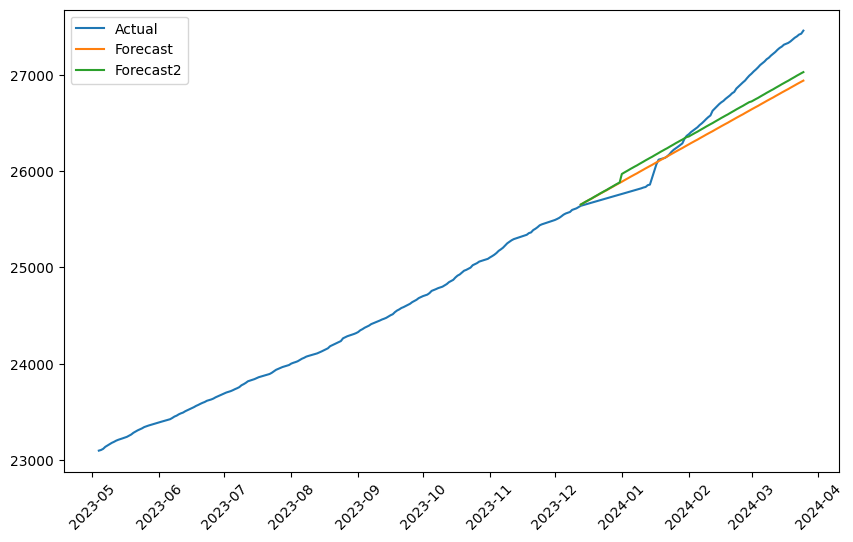

In [ ]:
# Visualization of predictions vs actual data
plt.figure(figsize=(10, 6))
# Plot actual data
plt.plot(prophet_df['ds'], prophet_df['y'], label='Actual')
# Plot forecasted data
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
# Plot forecasted data
plt.plot(forecast2['ds'], forecast2['yhat'], label='Forecast2')

# Fill area between forecast confidence intervals
#plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='k', alpha=0.2)

plt.legend()
# Format the dates on x-axis

plt.xticks(rotation=45)  # Rotate dates for better readability
import plotly.graph_objs as go

# Trace for actual data
actual_trace = go.Scatter(x=prophet_df['ds'], y=prophet_df['y'], mode='lines', name='Actual')

# Trace for forecasted data
forecast_trace = go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast')

# Trace for second forecasted data
forecast2_trace = go.Scatter(x=forecast2['ds'], y=forecast2['yhat'], mode='lines', name='Forecast2')
plt.show()

In [ ]:
import plotly.graph_objs as go

# Traces for the actual data, forecast, and forecast2
actual_trace = go.Scatter(x=prophet_df['ds'], y=prophet_df['y'], mode='lines', name='Actual')
forecast_trace = go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast')
forecast2_trace = go.Scatter(x=forecast2['ds'], y=forecast2['yhat'], mode='lines', name='Forecast2')

data = [actual_trace, forecast_trace, forecast2_trace]

# Defining the layout with x-axis range slider. Y-axis automatically adjusts.
layout = go.Layout(
    title='Predictions vs Actual Data',
    xaxis=dict(
        title='Date',
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1M', step='month', stepmode='backward'),
                dict(count=6, label='6M', step='month', stepmode='backward'),
                dict(count=1, label='YTD', step='year', stepmode='todate'),
                dict(count=1, label='1Y', step='year', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis=dict(title='Value (Kwh)', autorange=True),
)

fig = go.Figure(data=data, layout=layout)

fig.show()


In [ ]:
# Assuming 'forecast' and 'forecast2' are your DataFrames with predictions
# Merge the 'forecast' DataFrame with 'forecast2' on the 'ds' column
# This will give you a DataFrame with 'ds', 'yhat' from 'forecast', and 'yhat' from 'forecast2'
combined_forecast2 = pd.merge(forecast[['ds', 'yhat']], forecast2[['ds', 'yhat']], on='ds', suffixes=('', '2'))

# Rename columns to clarify the source of 'yhat' values
combined_forecast2.rename(columns={'yhat': 'yhat_forecast', 'yhat': 'yhat_forecast2'}, inplace=True)

# Now 'combined_forecast' contains the date ('ds'), 'yhat' from the first forecast, and 'yhat' from the second forecast
print(combined_forecast2.head())


          ds  yhat_forecast2         yhat2
0 2023-12-13    25654.253128  25654.431999
1 2023-12-14    25666.790368  25667.209476
2 2023-12-15    25679.759243  25680.641387
3 2023-12-16    25691.945938  25692.963575
4 2023-12-17    25704.251237  25705.655903


In [ ]:
# Save the combined forecast to a CSV file
combined_forecast2.to_csv('combined_forecast.csv', index=False)

In [ ]:
from prophet.plot import plot_plotly,  plot_components_plotly
import plotly.offline as py


# Plot the forecast components interactively
fig4 = plot_components_plotly(model, forecast)
fig4.show()

In [ ]:
from prophet.plot import plot_plotly,  plot_components_plotly
import plotly.offline as py


# Plot the forecast components interactively
fig5 = plot_components_plotly(model2, forecast2)
fig5.show()

In [ ]:
import plotly.graph_objs as go

# Extract traces from the first forecast plot
traces1 = [go.Scatter(x=prophet_df['ds'], y=prophet_df['y'], mode='lines', name='Actual')]

# Extract traces from the second forecast plot
traces2 = [go.Scatter(x=forecast2['ds'], y=forecast2['yhat'], mode='lines', name='Forecast2')]

# Create a new figure and add all traces
fig = go.Figure()

# Add traces from the first forecast
for trace in traces1:
    fig.add_trace(trace)

# Add traces from the second forecast
for trace in traces2:
    fig.add_trace(trace)

# Optional: Customize the layout
fig.update_layout(title='Combined Forecast',
                  xaxis_title='Date',
                  yaxis_title='Value',
                  legend_title='Legend')

# Show the combined figure
fig.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming 'actuals' is a DataFrame containing the actual values for the forecast period with columns ['ds', 'y']
# For demonstration, replace 'actuals' with your actual test dataset
actuals = pd.DataFrame({'ds': prophet_df['ds'], 'y': prophet_df['y']})

# Calculate MAE, RMSE, and MAPE for Model 1&2
mae_model1 = round(mean_absolute_error(test_prophet_df['y'], combined_forecast2['yhat_forecast2']),1)
mae_model2 = round(mean_absolute_error(test_prophet_df['y'], combined_forecast2['yhat2']),1)

rmse_model1 = round(np.sqrt(mean_squared_error(test_prophet_df['y'], combined_forecast2['yhat_forecast2'])),1)
rmse_model2 = round(np.sqrt(mean_squared_error(test_prophet_df['y'], combined_forecast2['yhat2'])),1)

In [ ]:


print(f"Model 1 - MAE: {mae_model1},RMSE: {rmse_model1}%")
print(f"Model 2 - MAE: {mae_model2},RMSE: {rmse_model2}%")



Model 1 - MAE: 856.0,RMSE: 979.0%
Model 2 - MAE: 867.9,RMSE: 994.1%
